In [4]:
%load_ext autoreload
%autoreload 2
from collections import Counter
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from gensim.models.word2vec import Word2VecKeyedVectors

from songrecsys import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
sns.set_style('white')
sns.set_context("notebook", rc={'lines.linewidth': 5})

data: Data = load(DataFormat.pickle)
mgr = Manager(['spotify'], LyricsGenius, data, override=True)
pisr = PISR(mgr)
data = pisr.get_playlist_pairs()

Loading pickle from data/data... OK
Loading config from config.json
Loading corpus from data/corpus.txt


In [38]:
def get_preds(max_epochs:int) -> pd.DataFrame:
    df_data = {'epoch': [], 'track_cnt': []}
    for epoch in tqdm(list(range(1, max_epochs + 1)), 'Gathering data'):
        model: Word2VecKeyedVectors = pisr.get_model(epochs=epoch)
        playlist: List[str] = data[0]
        song: str = playlist[0]
        songs = model.most_similar(song, topn=5)
        songs_cnt = sum([pred_song[0] in playlist and pred_song[0] != song for pred_song in songs])
        # for idx, pred_song in enumerate(songs):
        #     if pred_song[0] in playlist and pred_song[0] != song:
        #         print(f'{idx}.', pred_song, 'is in playlist')
        df_data['epoch'].append(epoch)
        df_data['track_cnt'].append(songs_cnt)
    df_data = pd.DataFrame.from_dict(df_data)
    return df_data

In [39]:
def plot(df_data: pd.DataFrame):
    plt.figure(figsize=(16, 9))
    return sns.barplot(data=df_data, x='epoch', y='track_cnt', color='black')

epoch        52
track_cnt     5
Name: 51, dtype: int64

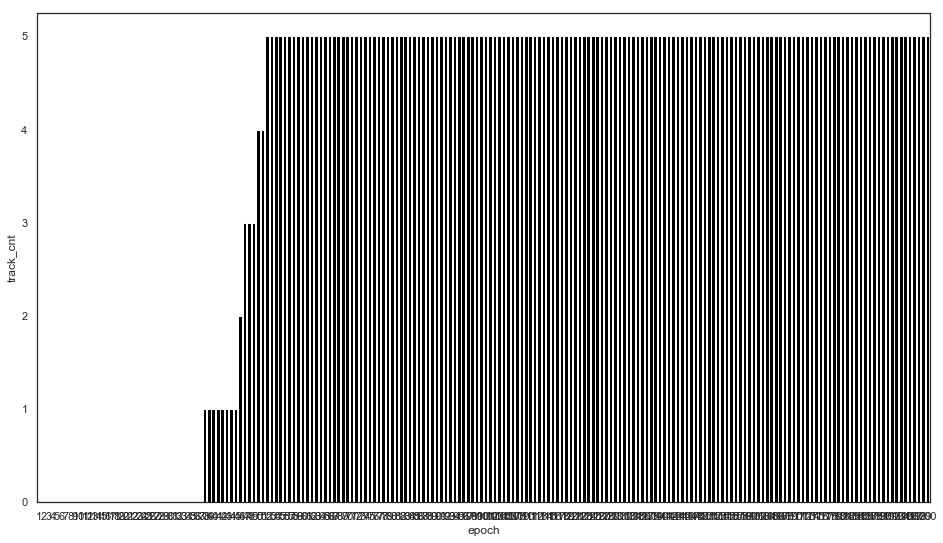

In [47]:
df_data  = get_preds(200)
plot(df_data)
df_data.iloc[df_data.idxmax(axis=0).track_cnt]

In [43]:
model = pisr.train_w2v_model([list(chain(*data))], epochs=200, size=300)